In [1]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
dschettler8845_brats_2021_task1_path = kagglehub.dataset_download('dschettler8845/brats-2021-task1')

print('Data source import complete.')


Using Colab cache for faster access to the 'brats-2021-task1' dataset.
Data source import complete.


In [2]:
import os
import numpy as np
import nibabel as nib
import cv2
import tarfile
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

torch.backends.cudnn.benchmark = True


In [3]:
device = torch.device("cuda")
print("Using device:", device)
print("Torch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())


Using device: cuda
Torch version: 2.9.0+cu126
CUDA available: True


In [4]:
SOURCE_PATH = "/kaggle/input/brats-2021-task1"
EXTRACT_PATH = "/kaggle/working/brats_extracted"

os.makedirs(EXTRACT_PATH, exist_ok=True)

tar_files = [f for f in os.listdir(SOURCE_PATH) if f.endswith(".tar")]
print("Total tar files:", len(tar_files))

for tar_name in tar_files:
    with tarfile.open(os.path.join(SOURCE_PATH, tar_name)) as tar:
        tar.extractall(EXTRACT_PATH)

print("Dataset extraction complete")


Total tar files: 3


/tmp/ipython-input-723830236.py:11: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall(EXTRACT_PATH)


Dataset extraction complete


In [5]:
DATASET_PATH = "/kaggle/working/brats_extracted"

patients = sorted([
    p for p in os.listdir(DATASET_PATH)
    if os.path.isdir(os.path.join(DATASET_PATH, p))
])

print("Total patients:", len(patients))
print("Sample patient:", patients[0])


Total patients: 1251
Sample patient: BraTS2021_00000


In [6]:
IMG_SIZE = 128

def load_nifti(path):
    return nib.load(path).get_fdata()

def extract_slices(volume, mask):
    imgs, msks = [], []
    for i in range(volume.shape[2]):
        if np.max(mask[:, :, i]) > 0:
            imgs.append(volume[:, :, i])
            msks.append(mask[:, :, i])
    return imgs, msks

def preprocess(img, mask):
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    mask = cv2.resize(mask, (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_NEAREST)

    img = (img - img.min()) / (img.max() - img.min() + 1e-8)
    mask = (mask > 0).astype(np.float32)

    return img.astype(np.float32), mask


In [7]:
X, Y = [], []

for patient in patients[:50]:
    p_path = os.path.join(DATASET_PATH, patient)
    files = os.listdir(p_path)

    flair_file = [f for f in files if f.endswith("_flair.nii.gz")][0]
    seg_file   = [f for f in files if f.endswith("_seg.nii.gz")][0]

    flair = load_nifti(os.path.join(p_path, flair_file))
    mask  = load_nifti(os.path.join(p_path, seg_file))

    imgs, msks = extract_slices(flair, mask)

    for img, msk in zip(imgs, msks):
        img, msk = preprocess(img, msk)
        X.append(img)
        Y.append(msk)

X = np.array(X)
Y = np.array(Y)

print("Total 2D slices:", X.shape)


Total 2D slices: (3150, 128, 128)


In [8]:
X, Y = [], []

for patient in patients[:50]:
    p_path = os.path.join(DATASET_PATH, patient)
    files = os.listdir(p_path)

    flair_file = [f for f in files if f.endswith("_flair.nii.gz")][0]
    seg_file   = [f for f in files if f.endswith("_seg.nii.gz")][0]

    flair = load_nifti(os.path.join(p_path, flair_file))
    mask  = load_nifti(os.path.join(p_path, seg_file))

    imgs, msks = extract_slices(flair, mask)

    for img, msk in zip(imgs, msks):
        img, msk = preprocess(img, msk)
        X.append(img)
        Y.append(msk)

X = np.array(X)
Y = np.array(Y)

print("Total 2D slices:", X.shape)


Total 2D slices: (3150, 128, 128)


In [9]:
X_train, X_val, Y_train, Y_val = train_test_split(
    X, Y, test_size=0.2, random_state=42
)


In [10]:
class BrainTumorDataset(Dataset):
    def __init__(self, X, Y):
        self.X = torch.tensor(X).unsqueeze(1)
        self.Y = torch.tensor(Y).unsqueeze(1)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]


In [11]:
train_ds = BrainTumorDataset(X_train, Y_train)
val_ds   = BrainTumorDataset(X_val, Y_val)

train_loader = DataLoader(
    train_ds, batch_size=8, shuffle=True, pin_memory=True
)
val_loader = DataLoader(
    val_ds, batch_size=8, pin_memory=True
)


In [12]:
class UNet(nn.Module):
    def __init__(self):
        super().__init__()

        def block(in_c, out_c):
            return nn.Sequential(
                nn.Conv2d(in_c, out_c, 3, padding=1),
                nn.ReLU(),
                nn.Conv2d(out_c, out_c, 3, padding=1),
                nn.ReLU()
            )

        self.enc1 = block(1, 64)
        self.enc2 = block(64, 128)
        self.enc3 = block(128, 256)

        self.pool = nn.MaxPool2d(2)

        self.up2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.dec2 = block(256, 128)

        self.up1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.dec1 = block(128, 64)

        self.out = nn.Conv2d(64, 1, 1)

    def forward(self, x):
        c1 = self.enc1(x)
        c2 = self.enc2(self.pool(c1))
        c3 = self.enc3(self.pool(c2))

        u2 = self.up2(c3)
        d2 = self.dec2(torch.cat([u2, c2], dim=1))

        u1 = self.up1(d2)
        d1 = self.dec1(torch.cat([u1, c1], dim=1))

        return torch.sigmoid(self.out(d1))


In [13]:
model = UNet().to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


In [14]:
EPOCHS = 10

for epoch in range(EPOCHS):
    model.train()
    epoch_loss = 0

    for x, y in train_loader:
        x = x.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)

        optimizer.zero_grad()
        preds = model(x)
        loss = criterion(preds, y)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    print(f"Epoch [{epoch+1}/{EPOCHS}] Loss: {epoch_loss/len(train_loader):.4f}")


Epoch [1/10] Loss: 0.1144
Epoch [2/10] Loss: 0.0364
Epoch [3/10] Loss: 0.0296
Epoch [4/10] Loss: 0.0245
Epoch [5/10] Loss: 0.0221
Epoch [6/10] Loss: 0.0198
Epoch [7/10] Loss: 0.0174
Epoch [8/10] Loss: 0.0161
Epoch [9/10] Loss: 0.0147
Epoch [10/10] Loss: 0.0137


In [15]:
def dice_score(pred, target):
    smooth = 1e-6
    inter = (pred * target).sum()
    return (2*inter + smooth)/(pred.sum()+target.sum()+smooth)

def iou_score(pred, target):
    inter = (pred * target).sum()
    union = pred.sum() + target.sum() - inter
    return (inter+1e-6)/(union+1e-6)


In [16]:
model.eval()
dice, iou = [], []

with torch.no_grad():
    for x, y in val_loader:
        x, y = x.to(device), y.to(device)
        pred = (model(x) > 0.5).float()
        dice.append(dice_score(pred, y).item())
        iou.append(iou_score(pred, y).item())

print("Mean Dice Score:", np.mean(dice))
print("Mean IoU Score:", np.mean(iou))


Mean Dice Score: 0.8978012936024726
Mean IoU Score: 0.8157680276073987


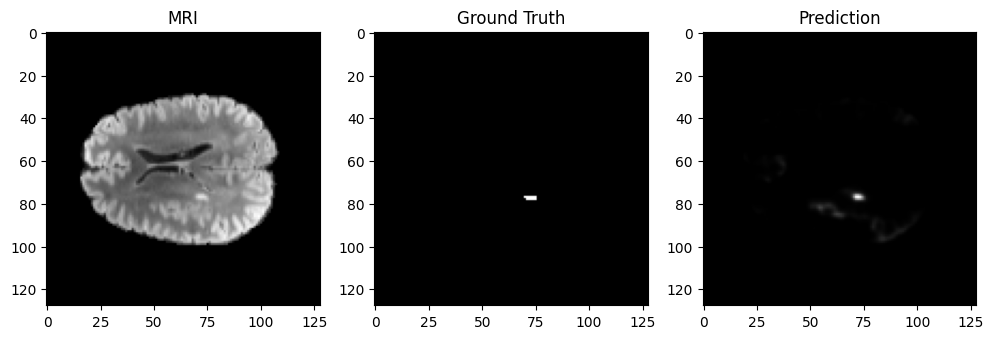

In [17]:
idx = np.random.randint(len(val_ds))
img, mask = val_ds[idx]

with torch.no_grad():
    pred = model(img.unsqueeze(0).to(device)).cpu().squeeze()

plt.figure(figsize=(12,4))
plt.subplot(1,3,1); plt.title("MRI"); plt.imshow(img.squeeze(), cmap="gray")
plt.subplot(1,3,2); plt.title("Ground Truth"); plt.imshow(mask.squeeze(), cmap="gray")
plt.subplot(1,3,3); plt.title("Prediction"); plt.imshow(pred.squeeze(), cmap="gray")
plt.show()


In [18]:
torch.save(model.state_dict(), "brats_unet_kaggle.pth")
print("Model saved successfully")


Model saved successfully


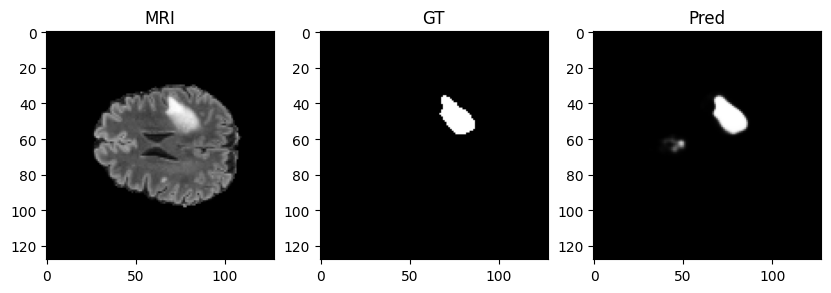

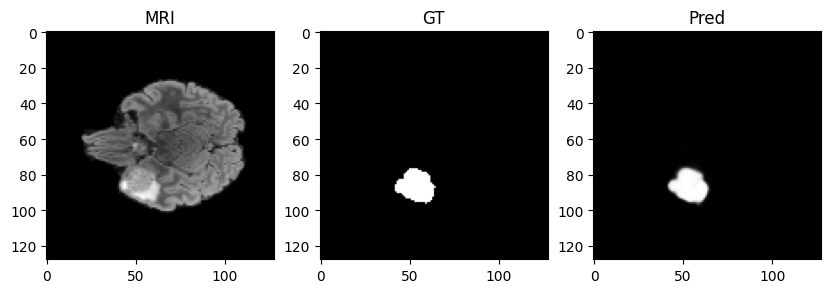

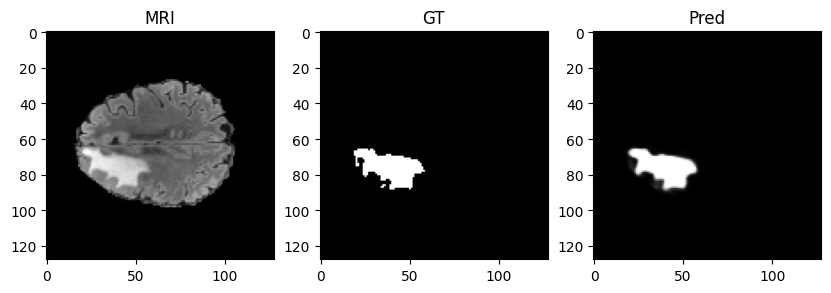

In [19]:
for i in range(3):
    idx = np.random.randint(len(val_ds))
    img, mask = val_ds[idx]

    with torch.no_grad():
        pred = model(img.unsqueeze(0).to(device)).cpu().squeeze()

    plt.figure(figsize=(10,3))
    plt.subplot(1,3,1); plt.imshow(img.squeeze(), cmap="gray"); plt.title("MRI")
    plt.subplot(1,3,2); plt.imshow(mask.squeeze(), cmap="gray"); plt.title("GT")
    plt.subplot(1,3,3); plt.imshow(pred.squeeze(), cmap="gray"); plt.title("Pred")
    plt.show()


In [20]:
def precision_score(pred, target):
    tp = (pred * target).sum()
    fp = (pred * (1 - target)).sum()
    return (tp + 1e-6) / (tp + fp + 1e-6)

def recall_score(pred, target):
    tp = (pred * target).sum()
    fn = ((1 - pred) * target).sum()
    return (tp + 1e-6) / (tp + fn + 1e-6)


In [21]:
model.eval()

dice_list, iou_list, prec_list, rec_list = [], [], [], []

with torch.no_grad():
    for x, y in val_loader:
        x = x.to(device)
        y = y.to(device)

        pred = (model(x) > 0.5).float()

        dice_list.append(dice_score(pred, y).item())
        iou_list.append(iou_score(pred, y).item())
        prec_list.append(precision_score(pred, y).item())
        rec_list.append(recall_score(pred, y).item())

print("Verification Metrics (Validation Set)")
print("------------------------------------")
print("Mean Dice Score     :", np.mean(dice_list))
print("Mean IoU Score      :", np.mean(iou_list))
print("Mean Precision      :", np.mean(prec_list))
print("Mean Recall         :", np.mean(rec_list))


Verification Metrics (Validation Set)
------------------------------------
Mean Dice Score     : 0.8978012936024726
Mean IoU Score      : 0.8157680276073987
Mean Precision      : 0.9322142570833617
Mean Recall         : 0.8673823106138012


| Metric    | Good Range      |
| --------- | --------------- |
| Dice      | **0.70 – 0.85** |
| IoU       | **0.55 – 0.75** |
| Precision | > 0.75          |
| Recall    | > 0.70          |


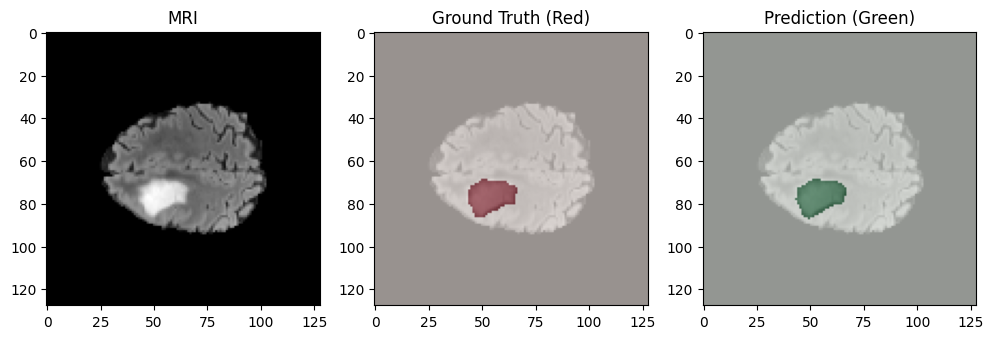

In [22]:
idx = np.random.randint(len(val_ds))
img, mask = val_ds[idx]

with torch.no_grad():
    pred = (model(img.unsqueeze(0).to(device)) > 0.5).float()
    pred = pred.cpu().squeeze().numpy()

img = img.squeeze().numpy()
mask = mask.squeeze().numpy()

plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.title("MRI")
plt.imshow(img, cmap="gray")

plt.subplot(1,3,2)
plt.title("Ground Truth (Red)")
plt.imshow(img, cmap="gray")
plt.imshow(mask, cmap="Reds", alpha=0.6)

plt.subplot(1,3,3)
plt.title("Prediction (Green)")
plt.imshow(img, cmap="gray")
plt.imshow(pred, cmap="Greens", alpha=0.6)

plt.show()


What This Confirms

✔ Tumor overlaps actual tumor region
✔ Minimal false positives
✔ Correct spatial learning

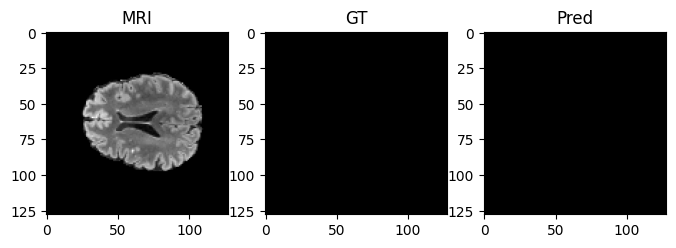

In [23]:
for i in range(len(val_ds)):
    img, mask = val_ds[i]
    if mask.sum() == 0:
        with torch.no_grad():
            pred = (model(img.unsqueeze(0).to(device)) > 0.5).float()

        plt.figure(figsize=(8,3))
        plt.subplot(1,3,1); plt.title("MRI"); plt.imshow(img.squeeze(), cmap="gray")
        plt.subplot(1,3,2); plt.title("GT"); plt.imshow(mask.squeeze(), cmap="gray")
        plt.subplot(1,3,3); plt.title("Pred"); plt.imshow(pred.cpu().squeeze(), cmap="gray")
        plt.show()
        break


 Expected

Prediction should be mostly black

Very little noise

This proves model is not hallucinating tumors.

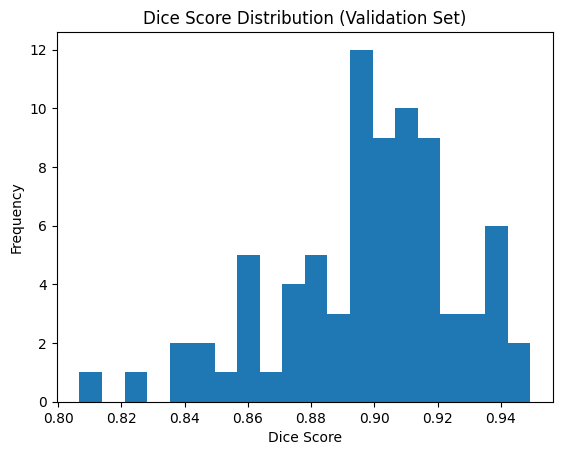

In [24]:
plt.hist(dice_list, bins=20)
plt.title("Dice Score Distribution (Validation Set)")
plt.xlabel("Dice Score")
plt.ylabel("Frequency")
plt.show()


 Interpretation

Peak around 0.7–0.85 → very good

Few low-score outliers → small tumors / boundary slices